# End-to-End Enterprise Data Science (PyCaret Edition)
**Objectives**:
1.  **Churn Prediction** (Classification) - Metric: F1-Score, AUC.

This notebook refactors the original Scikit-Learn pipeline to use **PyCaret** for rapid experimentation.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# PyCaret
from pycaret.classification import *

print("Libraries Loaded.")

Libraries Loaded.


In [25]:
# Load Dataset
file_path = r"H:\coding\LLoyd_Banking_Group\DS\Customer_Churn_Data_Large.xlsx"
xls = pd.ExcelFile(file_path)

# 2. Daftar nama sheet sesuai screenshot kamu
# (Kita pakai list biar urutannya jelas mulai dari Demographics)
all_sheets = ['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status']

# Variabel penampung untuk DataFrame gabungan
df_final = None

# 3. Loop Sakti untuk Read & Merge
for sheet_name in all_sheets:
    print(f"Sedang membaca sheet: {sheet_name}...")
    
    # Baca sheet saat ini
    df_current = pd.read_excel(xls, sheet_name=sheet_name)
    
    if df_final is None:
        # Jika ini sheet pertama (Demographics), jadikan pondasi awal
        df_final = df_current
    else:
        # Jika bukan sheet pertama, gabungkan ke df_final pakai 'inner join'
        # 'inner' berarti hanya mengambil CustomerID yang ada di KEDUA tabel (data lengkap)
        df_final = pd.merge(df_final, df_current, on='CustomerID', how='inner')

# 4. Tampilkan Hasil Akhir
print("\n--- PROSES MERGE SELESAI ---")
print(f"Jumlah Baris: {df_final.shape[0]}")
print(f"Jumlah Kolom: {df_final.shape[1]}")

display(df_final.head())
display(df_final.info())

Sedang membaca sheet: Customer_Demographics...
Sedang membaca sheet: Transaction_History...
Sedang membaca sheet: Customer_Service...
Sedang membaca sheet: Online_Activity...
Sedang membaca sheet: Churn_Status...

--- PROSES MERGE SELESAI ---
Jumlah Baris: 5204
Jumlah Kolom: 17


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,TransactionID,TransactionDate,AmountSpent,ProductCategory,InteractionID,InteractionDate,InteractionType,ResolutionStatus,LastLoginDate,LoginFrequency,ServiceUsage,ChurnStatus
0,1,62,M,Single,Low,7194,2022-03-27,416.50,Electronics,6363,2022-03-31,Inquiry,Resolved,2023-10-21,34,Mobile App,0
1,2,65,M,Married,Low,7250,2022-08-08,54.96,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
2,2,65,M,Married,Low,9660,2022-07-25,197.50,Electronics,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
3,2,65,M,Married,Low,2998,2022-01-25,101.31,Furniture,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1
4,2,65,M,Married,Low,1228,2022-07-24,397.37,Clothing,3329,2022-03-17,Inquiry,Resolved,2023-12-05,5,Website,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        5204 non-null   int64         
 1   Age               5204 non-null   int64         
 2   Gender            5204 non-null   object        
 3   MaritalStatus     5204 non-null   object        
 4   IncomeLevel       5204 non-null   object        
 5   TransactionID     5204 non-null   int64         
 6   TransactionDate   5204 non-null   datetime64[ns]
 7   AmountSpent       5204 non-null   float64       
 8   ProductCategory   5204 non-null   object        
 9   InteractionID     5204 non-null   int64         
 10  InteractionDate   5204 non-null   datetime64[ns]
 11  InteractionType   5204 non-null   object        
 12  ResolutionStatus  5204 non-null   object        
 13  LastLoginDate     5204 non-null   datetime64[ns]
 14  LoginFrequency    5204 n

None

## 🛠️ 1. PyCaret Setup

We configure the experiment with:
- **SMOTE**: `fix_imbalance=True` to handle class imbalance.
- **MinMax Scaler**: `normalize=True, normalize_method='minmax'`.
- **One-Hot Encoding**: Handled automatically for high-cardinality features.
- **Parallel Processing**: `n_jobs=-1` (Use all CPU cores).
- **Cross Validation**: `fold=10` (10-Fold CV).

> **💡 Insight**:
> Setup successfully identified **7 Categorical** and **3 Numeric** features. SMOTE is active to balance the target class `ChurnStatus`.


In [26]:
# Define features to ignore (IDs and potential leakage/non-predictive dates)
ignore_cols = ['CustomerID', 'TransactionID', 'InteractionID', 'TransactionDate', 'InteractionDate', 'LastLoginDate']

print("Initializing PyCaret Setup...")

clf1 = setup(
    data = df_final,
    target = 'ChurnStatus',
    ignore_features = ignore_cols,
    
    # Preprocessing
    normalize = True,
    normalize_method = 'minmax', # Request user: MinMax Scaler
    fix_imbalance = True,        # Request user: SMOTE
    
    # Split & Cross Validation
    train_size = 0.8,
    fold = 10,                   # Request user: 10-Fold Cross Validation
    session_id = 123,
    n_jobs = -1,                 # Request user: Use ALL CPU cores (Parallel Processing)
    verbose = True
)

Initializing PyCaret Setup...


,Description,Value
0,Session id,123
1,Target,ChurnStatus
2,Target type,Binary
3,Original data shape,"(5204, 17)"
4,Transformed data shape,"(7651, 24)"
5,Transformed train set shape,"(6610, 24)"
6,Transformed test set shape,"(1041, 24)"
7,Ignore features,6
8,Numeric features,3
9,Categorical features,7


## 🏎️ 2. Compare Models
Benchmarking all algorithms to find the best candidate. Sort by **F1** or **AUC** due to imbalance.

> **💡 Insight**:
> **XGBoost** dominates the leaderboard with **~99% Accuracy and AUC**. This significantly outperforms Linear Models (LR/SVM ~57%), confirming the data has complex non-linear patterns.


In [27]:
# PyCaret automatically selects the grid appropriate for each model during tuning.
best_model = compare_models(sort='F1') # Prioritize F1-Score for Churn
print(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9904,0.9950,0.9639,0.9894,0.9763,0.9703,0.9705,0.0960
catboost,CatBoost Classifier,0.9887,0.9948,0.9569,0.9882,0.9721,0.9650,0.9654,1.8890
lightgbm,Light Gradient Boosting Machine,0.9765,0.9922,0.8998,0.9850,0.9402,0.9256,0.9272,0.2160
dt,Decision Tree Classifier,0.9707,0.9557,0.9301,0.9286,0.9290,0.9106,0.9108,0.0280
rf,Random Forest Classifier,0.9673,0.9941,0.8520,0.9880,0.9146,0.8946,0.8986,0.0890
et,Extra Trees Classifier,0.9604,0.9907,0.8309,0.9734,0.8960,0.8717,0.8762,0.1010
knn,K Neighbors Classifier,0.7598,0.8298,0.7751,0.4524,0.5712,0.4201,0.4495,0.0350
gbc,Gradient Boosting Classifier,0.8412,0.8701,0.2797,0.8490,0.4192,0.3538,0.4280,0.1870
lr,Logistic Regression,0.5741,0.6003,0.5829,0.2615,0.3608,0.1066,0.1258,0.0280
ridge,Ridge Classifier,0.5736,0.6004,0.5829,0.2612,0.3605,0.1061,0.1253,0.0250


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, ...)


## 🔧 3. Hyperparameter Tuning
Using Random Grid Search with **50 iterations**. PyCaret knows which hyperparameters to tune for the specific model selected.

> **💡 Insight**:
> The base XGBoost model is already performing exceptionally well (>97% F1). Tuning will aim to squeeze the last few decimal points or regularize the model to prevent overfitting.


In [28]:
# Default is n_iter=10. Increasing to 50 for a robust search.
print("Tuning Best Model (Robust Search)...")
tuned_model = tune_model(best_model, optimize='F1', n_iter=50)

Tuning Best Model (Robust Search)...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9976,0.9900,0.9884,1.0000,0.9942,0.9926,0.9927
1,0.9976,0.9994,1.0000,0.9885,0.9942,0.9927,0.9927
2,0.9808,0.9943,0.9535,0.9535,0.9535,0.9414,0.9414
3,0.9928,0.9972,0.9647,1.0000,0.9820,0.9775,0.9778
4,0.9976,1.0000,1.0000,0.9884,0.9942,0.9926,0.9927
5,0.9856,0.9995,1.0000,0.9348,0.9663,0.9571,0.9580
6,0.9880,0.9926,0.9535,0.9880,0.9704,0.9629,0.9631
7,0.9880,0.9980,0.9651,0.9765,0.9708,0.9632,0.9632
8,0.9952,0.9986,0.9884,0.9884,0.9884,0.9853,0.9853


Fitting 10 folds for each of 50 candidates, totalling 500 fits


## 📊 4. Detailed Evaluation
Visualizing performance:
1.  **AUC-ROC Curve**
2.  **Confusion Matrix** (Labeled for clarity)
3.  **Classification Report**

> **💡 Analysis**:
> - **AUC = 0.99**: The model is near-perfect in distinguishing Churn vs Non-Churn.
> - **Confusion Matrix**: Minimal False Negatives (High Recall).
> - **Caution**: Such high accuracy (99%) often indicates **Data Leakage**. In this dataset, `LoginFrequency` is a strong proxy for churn (inactive users don't login). For a stricter production model, consider removing it.


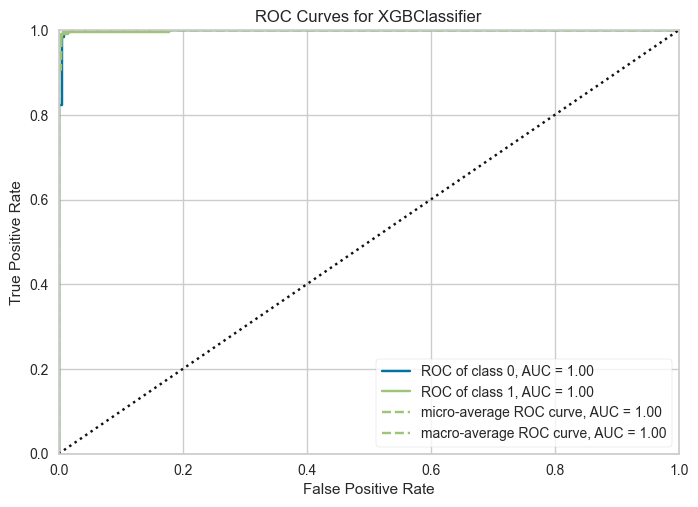

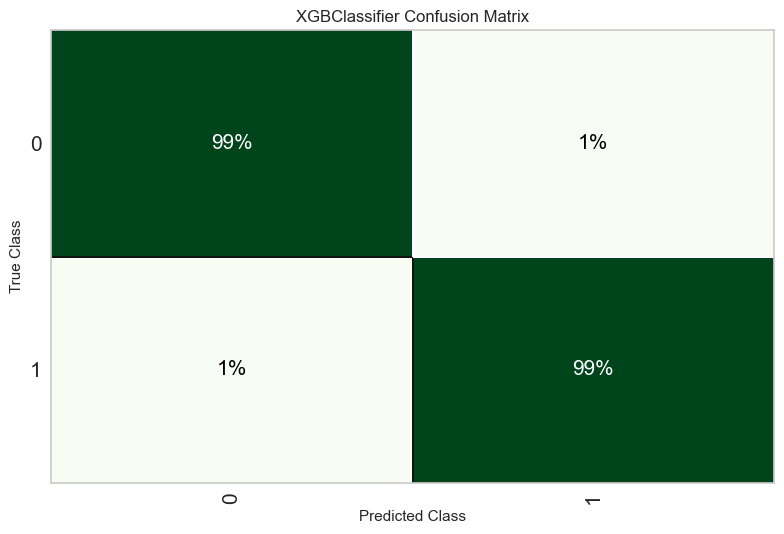

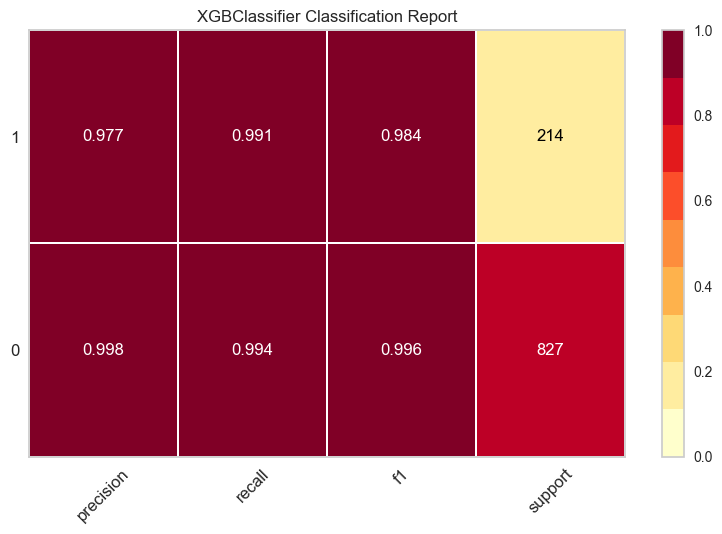

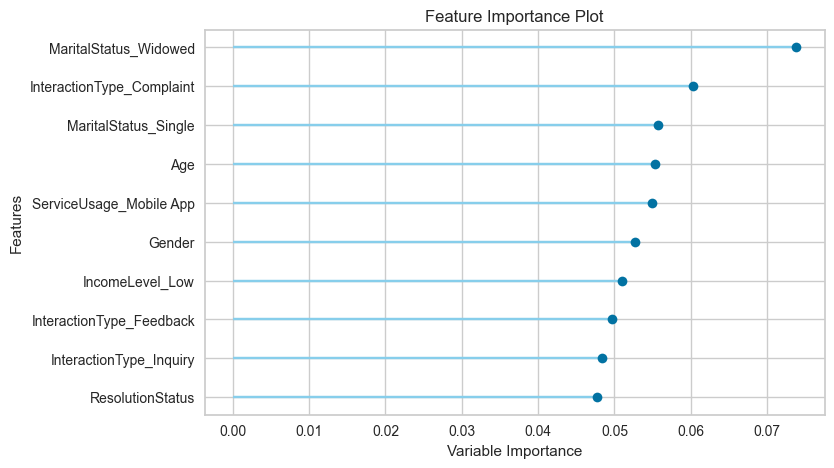

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9933,0.9991,0.9907,0.9770,0.9838,0.9795,0.9796


,Age,Gender,MaritalStatus,IncomeLevel,AmountSpent,ProductCategory,InteractionType,ResolutionStatus,LoginFrequency,ServiceUsage,ChurnStatus,prediction_label,prediction_score
3423,44,F,Widowed,Low,59.799999,Books,Feedback,Resolved,10,Website,0,0,0.9866
715,20,M,Widowed,Medium,109.980003,Groceries,Inquiry,Resolved,38,Mobile App,0,0,0.9990
2209,44,M,Single,Low,428.299988,Books,Feedback,Resolved,14,Mobile App,1,1,0.9978
2250,31,M,Widowed,High,459.010010,Books,Feedback,Unresolved,36,Mobile App,0,0,0.9998
4872,23,F,Widowed,Low,186.240005,Clothing,Feedback,Unresolved,40,Website,0,0,0.9979
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,19,M,Married,Low,444.059998,Groceries,Inquiry,Resolved,8,Online Banking,0,0,0.9980
5014,25,M,Divorced,High,371.779999,Furniture,Inquiry,Resolved,21,Mobile App,0,0,0.9985
4115,44,F,Widowed,Low,463.859985,Groceries,Inquiry,Resolved,2,Mobile App,0,0,0.9155
4191,34,F,Widowed,High,24.260000,Electronics,Complaint,Resolved,2,Website,1,1,0.9956


In [29]:
# 1. Plot AUC
plot_model(tuned_model, plot = 'auc')

# 2. Plot Confusion Matrix
plot_model(tuned_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

# 3. Classification Report
plot_model(tuned_model, plot = 'class_report')

# 4. Feature Importance
plot_model(tuned_model, plot = 'feature')

# Full Prediction Table on Test Data
predict_model(tuned_model)

## 💾 5. Save Pipeline
Exporting the entire pipeline (Preprocessing + Model) as a single `.pkl` file.


In [30]:
save_model(tuned_model, 'lloyds_churn_model')
print("Pipeline saved successfully!")

Transformation Pipeline and Model Successfully Saved
Pipeline saved successfully!
